### Extreme Gradient Boosting (XGBoost)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#### Load ChEMBL bioactivity data

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools

chembl_bioactivity_df = pd.read_pickle('../data/chembl_bioactivity_data.pkl')
chembl_bioactivity_df.head(2)

,molecule_chembl_id,molecule_pref_name,canonical_smiles,pchembl_value,standard_type,standard_relation,standard_value,standard_units,potential_duplicate,target_pref_name,target_organism,assay_type,assay_description,chembl_id_duplicate,mean_pchembl_value,max_pchembl_value,min_pchembl_value,core_smiles,Mol,Scaffold
0,CHEMBL10,SB-203580,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,5.70,Kd,=,2000.0,nM,False,Tyrosine-protein kinase TYK2,Homo sapiens,B,Binding constant for TYK2(JH2domain-pseudokina...,False,5.70,5.70,5.70,c1ccc(-c2nc(-c3ccccc3)c(-c3ccncc3)[nH]2)cc1,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i..."
1,CHEMBL1076700,None,Cc1cc(Nc2nc3cccc(-c4cc(F)c(CN5CCOCC5)c(F)c4)c3...,7.01,IC50,=,97.0,nM,False,Tyrosine-protein kinase TYK2,Homo sapiens,B,Inhibition of GST-tagged TYK2 assessed as inhi...,False,7.01,7.01,7.01,c1ccc(Nc2nc3cccc(-c4ccc(CN5CCOCC5)cc4)c3o2)cc1,"<img data-content=""rdkit/molecule"" src=""data:i...","<img data-content=""rdkit/molecule"" src=""data:i..."


In [3]:
chembl_bioactivity_df.shape

(1502, 20)

In [4]:
from rdkit.Chem.SaltRemover import SaltRemover

def unsalt(smiles):
    remover = SaltRemover()
    #print(remover.salts)
    mol = Chem.MolFromSmiles(smiles)
    mol, deleted = remover.StripMolWithDeleted(mol)
    #print([Chem.MolToSmarts(s) for s in deleted])
    return Chem.MolToSmiles(mol, True)

chembl_bioactivity_ml_df = chembl_bioactivity_df[['molecule_chembl_id', 'canonical_smiles', 'mean_pchembl_value']].copy()

#remove salts
smiles = list(map(lambda i: unsalt(i), list(chembl_bioactivity_ml_df['canonical_smiles'])))

chembl_bioactivity_ml_df['smiles']  = smiles
#chembl_bioactivity_ml_df.head()

mols = [Chem.MolFromSmiles(smi) for smi in chembl_bioactivity_ml_df['smiles']]  #sanitize=True default

#### Featurize the ChEMBL dataset

#### Calculate Molecular Descriptors

In [5]:
import deepchem as dc

#if use_fragment = True, a total of 208 descriptors are returned to include fragment binary descriptors like 'fr_'
md_featurizer = dc.feat.RDKitDescriptors(use_fragment = False)

features_md = md_featurizer.featurize(mols)
#features_md is a N x 123 array containing the 123 molecular descriptors(physiochemical properties) for the 1502 molecules
print(features_md.shape)
features_md[:5]

(1502, 123)


array([[ 1.33377069e+01, -1.02754413e+00,  1.33377069e+01,
         2.88772971e-01,  5.25196404e-01,  3.77444000e+02,
         3.61316000e+02,  3.77099811e+02,  1.34000000e+02,
         0.00000000e+00,  1.51945536e-01, -6.11646138e-01,
         6.11646138e-01,  1.51945536e-01,  8.51851852e-01,
         1.48148148e+00,  2.11111111e+00,  3.22277374e+01,
         1.00631031e+01,  2.15653172e+00, -2.03749157e+00,
         2.32663597e+00, -1.95909026e+00,  7.90297649e+00,
         6.00587178e-01,  1.83223649e+00,  1.04524911e+03,
         1.88027541e+01,  1.45170915e+01,  1.53335881e+01,
         1.31141935e+01,  8.31838406e+00,  9.87646226e+00,
         6.03030029e+00,  7.40995310e+00,  4.25014686e+00,
         5.18616699e+00,  2.85853311e+00,  3.37789251e+00,
        -2.96000000e+00,  3.14577780e+00,  1.74536410e+01,
         7.34321150e+00,  3.62549170e+00,  1.58876011e+02,
         9.53672839e+00,  1.78973945e+01,  4.89548348e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [6]:
#from rdkit.ML.Descriptors import MoleculeDescriptors

#calculated rdkit descriptors
descriptors = []
descList = []
from rdkit.Chem import Descriptors
for descriptor, function in Descriptors.descList:
    if descriptor.startswith('fr_'):
        continue
    descriptors.append(descriptor)
    descList.append((descriptor, function))
print(descriptors)
print(len(descriptors))

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

#### Dataset preparation

In [7]:
dataset = pd.DataFrame(data=features_md, columns=descriptors)
dataset['Activity'] = chembl_bioactivity_ml_df['mean_pchembl_value'].astype(float)
dataset.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Activity
0,13.337707,-1.027544,13.337707,0.288773,0.525196,377.444,361.316,377.099811,134.0,0.0,...,1.0,6.0,4.0,0.0,0.0,0.0,4.0,4.68220,104.9811,5.70
1,15.103447,-0.598463,15.103447,0.045197,0.252238,563.649,528.369,563.270796,216.0,0.0,...,2.0,10.0,10.0,0.0,1.0,1.0,5.0,5.33872,155.4229,7.01
2,11.926602,-0.279010,11.926602,0.018898,0.597823,414.469,392.293,414.180424,156.0,0.0,...,2.0,8.0,6.0,0.0,1.0,1.0,4.0,2.97718,118.1709,6.40
3,15.037980,-0.597968,15.037980,0.045663,0.379810,506.553,478.329,506.212947,192.0,0.0,...,1.0,9.0,6.0,0.0,1.0,1.0,5.0,5.35902,137.9362,6.70
4,6.026013,0.382087,6.026013,0.382087,0.494826,376.412,356.252,376.142307,142.0,0.0,...,1.0,6.0,6.0,0.0,0.0,0.0,4.0,5.26420,108.8257,5.47


In [8]:
#### Summary of the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Columns: 124 entries, MaxEStateIndex to Activity
dtypes: float64(124)
memory usage: 1.4 MB


In [9]:
#### Summary statistics of the dataset
dataset.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Activity
count,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.0,...,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000,1502.000000
mean,11.312963,-0.953615,11.312963,0.197582,0.609834,385.936091,364.609836,385.540101,143.468708,0.0,...,2.099201,8.045273,4.498668,0.550599,0.363515,0.914115,4.200399,3.125656,105.148370,6.834001
std,2.736239,1.562339,2.736239,0.165961,0.157720,70.926322,67.302260,70.864217,26.974314,0.0,...,0.993054,1.994483,2.136186,0.653823,0.553302,0.747156,0.938722,1.147868,19.494897,0.891018
min,2.420090,-6.086026,2.420090,0.000205,0.044029,198.225000,188.145000,198.079313,74.000000,0.0,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-0.404900,58.548200,4.380000
25%,10.953619,-1.018870,10.953619,0.059952,0.499680,342.701500,325.811750,342.442604,126.000000,0.0,...,1.000000,7.000000,3.000000,0.000000,0.000000,0.000000,4.000000,2.380820,92.923600,6.210000
50%,12.260983,-0.412040,12.260983,0.147885,0.604211,383.419000,362.714000,383.119027,142.000000,0.0,...,2.000000,8.000000,4.000000,0.000000,0.000000,1.000000,4.000000,3.079500,103.646300,6.800000
75%,12.980270,0.002530,12.980270,0.301707,0.742152,423.948000,402.330000,423.182588,158.000000,0.0,...,3.000000,9.000000,6.000000,1.000000,1.000000,1.000000,5.000000,3.872705,116.036800,7.440000
max,16.124211,0.970648,16.124211,0.970648,0.929103,915.848000,859.400000,915.430234,350.000000,0.0,...,16.000000,22.000000,24.000000,4.000000,3.000000,4.000000,11.000000,7.613620,253.577300,9.700000


<AxesSubplot:>

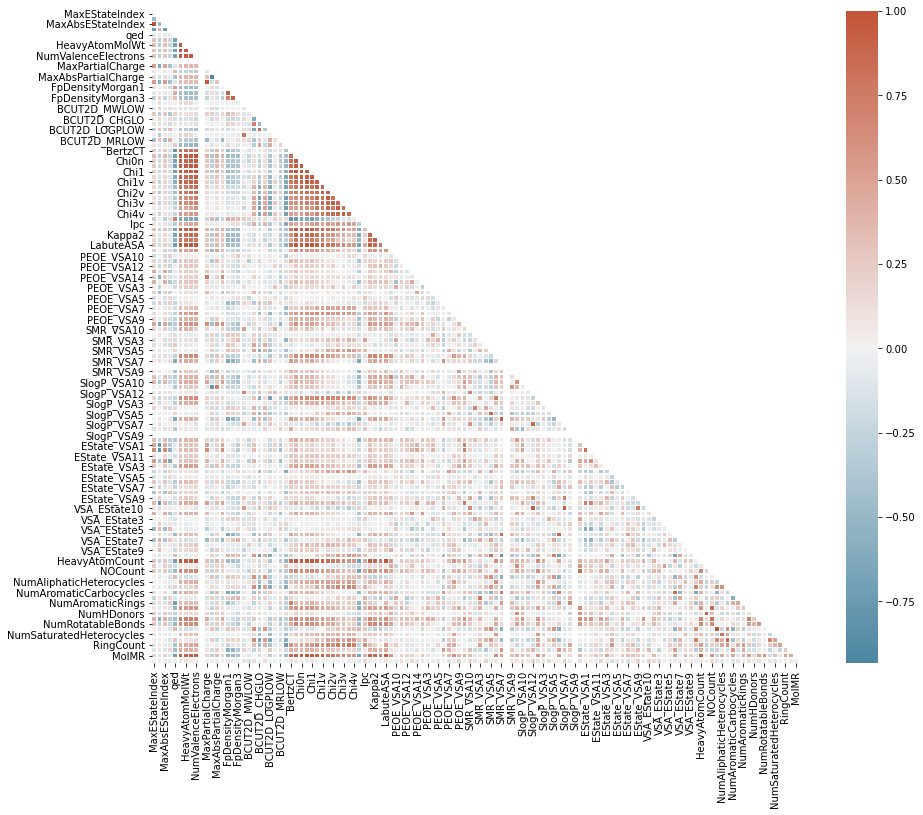

In [10]:
#### Correlation matrix
corr=dataset.corr()
mask=np.triu(np.ones_like(corr,dtype=bool))
f,ax = plt.subplots(figsize=(15,12))
cmap = sns.diverging_palette(230,20, as_cmap=True)
sns.heatmap(corr,cmap=cmap,mask=mask,linewidth=0.5,square=True,center=0)

In [11]:
#### Distributions of descriptors
#color = '#a9cce3'
#dataset.hist(bins=15,figsize=(25,15),color=color)
#plt.rcParams['font.size'] = 18
#plt.show()

In [12]:
#### Make Activity categorical
dataset['Activity'] = np.where(dataset['Activity'] >=7.0, 1, 0)
dataset.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Activity
0,13.337707,-1.027544,13.337707,0.288773,0.525196,377.444,361.316,377.099811,134.0,0.0,...,1.0,6.0,4.0,0.0,0.0,0.0,4.0,4.68220,104.9811,0
1,15.103447,-0.598463,15.103447,0.045197,0.252238,563.649,528.369,563.270796,216.0,0.0,...,2.0,10.0,10.0,0.0,1.0,1.0,5.0,5.33872,155.4229,1
2,11.926602,-0.279010,11.926602,0.018898,0.597823,414.469,392.293,414.180424,156.0,0.0,...,2.0,8.0,6.0,0.0,1.0,1.0,4.0,2.97718,118.1709,0
3,15.037980,-0.597968,15.037980,0.045663,0.379810,506.553,478.329,506.212947,192.0,0.0,...,1.0,9.0,6.0,0.0,1.0,1.0,5.0,5.35902,137.9362,0
4,6.026013,0.382087,6.026013,0.382087,0.494826,376.412,356.252,376.142307,142.0,0.0,...,1.0,6.0,6.0,0.0,0.0,0.0,4.0,5.26420,108.8257,0


#### Create feature matrix (X) and target vector (y)

In [13]:
X = dataset.drop('Activity', axis=1)
y = dataset['Activity']

In [14]:
X.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR
0,13.337707,-1.027544,13.337707,0.288773,0.525196,377.444,361.316,377.099811,134.0,0.0,...,3.0,1.0,6.0,4.0,0.0,0.0,0.0,4.0,4.68220,104.9811
1,15.103447,-0.598463,15.103447,0.045197,0.252238,563.649,528.369,563.270796,216.0,0.0,...,7.0,2.0,10.0,10.0,0.0,1.0,1.0,5.0,5.33872,155.4229
2,11.926602,-0.279010,11.926602,0.018898,0.597823,414.469,392.293,414.180424,156.0,0.0,...,7.0,2.0,8.0,6.0,0.0,1.0,1.0,4.0,2.97718,118.1709
3,15.037980,-0.597968,15.037980,0.045663,0.379810,506.553,478.329,506.212947,192.0,0.0,...,6.0,1.0,9.0,6.0,0.0,1.0,1.0,5.0,5.35902,137.9362
4,6.026013,0.382087,6.026013,0.382087,0.494826,376.412,356.252,376.142307,142.0,0.0,...,6.0,1.0,6.0,6.0,0.0,0.0,0.0,4.0,5.26420,108.8257


In [15]:
y.head()

0    0
1    1
2    0
3    0
4    0
Name: Activity, dtype: int32

#### Split dataset in train and test datasets

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [17]:
X_train.shape

(1201, 123)

In [18]:
X_test.shape

(301, 123)

#### XGBoost Classifier model

In [19]:
# ! pip install xgboost

In [20]:
from xgboost import XGBClassifier

params = {'objective':'binary:logistic',
          'max_depth':5, 
          'alpha':10, 
          'learning_rate':0.1, 
          'n_estimators':250,
          'random_state':42}

xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=250,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=10, ...)

In [21]:
y_pred = xgb_clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.7508305647840532

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=[1,0])
print(cm)

[[ 75  47]
 [ 28 151]]


In [24]:
from sklearn.metrics import classification_report

cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       179
           1       0.73      0.61      0.67       122

    accuracy                           0.75       301
   macro avg       0.75      0.73      0.73       301
weighted avg       0.75      0.75      0.75       301



#### Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

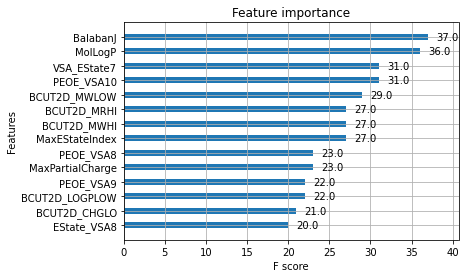

In [25]:
from xgboost import plot_importance
plot_importance(xgb_clf, height=0.4, max_num_features=14)

#### XGBoost k-fold cross validation model

In [26]:
#### convert the dataset into the Dmatrix optimized data structure supported by XGBoost 
#### that gives its performance and efficiency gains.

from xgboost import DMatrix

data_dmatrix = DMatrix(data=X,label=y)

In [27]:
from xgboost import cv

params = {'objective':'binary:logistic',
          'max_depth':5, 
          'alpha':10, 
          'learning_rate':0.1, 
          'random_state':42, 
          'colsample_bytree':0.3}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=10,
            num_boost_round=50, early_stopping_rounds=10, metrics="auc", 
            as_pandas=True, seed=42)

In [28]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.756316,0.028012,0.693256,0.034613
1,0.795399,0.016045,0.727012,0.040259
2,0.822999,0.016507,0.753060,0.033410
3,0.834997,0.011209,0.764420,0.036087
4,0.844911,0.012166,0.778978,0.036158


In [29]:
xgb_cv.describe()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
count,50.000000,50.000000,50.000000,50.000000
mean,0.907912,0.005280,0.811231,0.046435
std,0.040941,0.005087,0.029082,0.005553
min,0.756316,0.002119,0.693256,0.033410
25%,0.894870,0.002469,0.803190,0.043062
50%,0.922035,0.002907,0.821932,0.048499
75%,0.936141,0.006290,0.829308,0.051149
max,0.945857,0.028012,0.836613,0.052615


#### XGBoost hyperparameters tuning with HYPEROPT Bayesian optimization

In [30]:
# ! pip install hyperopt

In [31]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [32]:
space={'max_depth': hp.quniform("max_depth", 4, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 10,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'eval_metric':"auc",
        'early_stopping_rounds': hp.uniform('early_stopping_rounds', 2, 20),
        'n_estimators': hp.uniform('n_estimators', 50, 500),
        'seed': 42}

In [33]:
def objective(space):
    clf=XGBClassifier(
                    n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    early_stopping_rounds= int(space['early_stopping_rounds']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [ ( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [34]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                      

SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                      

SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.6511627906976745                                                                                                                                                                                                
SCORE:                                                                                                                                                      

SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.6445182724252492                                                                                                                                                                                                
SCORE:                                                                                                                                                      

SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.6378737541528239                                                                                                                                                                                                
SCORE:                                                                                                                                                      

SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.6677740863787376                                                                                                                                                                                                
SCORE:                                                                                                                                                      

SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.6877076411960132                                                                                                                                                                                                
SCORE:                                                                                                                                                      

SCORE:                                                                                                                                                                                                            
0.6013289036544851                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.6810631229235881                                                                                                                                                                                                
SCORE:                                                                                                                                                      

SCORE:                                                                                                                                                                                                            
0.7009966777408638                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.6843853820598007                                                                                                                                                                                                
SCORE:                                                                                                                                                      

SCORE:                                                                                                                                                                                                            
0.6013289036544851                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.6910299003322259                                                                                                                                                                                                
SCORE:                                                                                                                                                      

SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                                                                            
0.5946843853820598                                                                                                                                                                                                
SCORE:                                                                                                                                                      

In [35]:
best_hyperparams

{'colsample_bytree': 0.6503389592410008,
 'early_stopping_rounds': 15.399743157367482,
 'gamma': 1.0068784160681286,
 'max_depth': 9.0,
 'min_child_weight': 1.0,
 'n_estimators': 276.7439637308449,
 'reg_alpha': 28.0,
 'reg_lambda': 0.29771951078812237}

In [36]:
import sklearn
print("Scikit-Learn: ", sklearn.__version__)

import rdkit
print("RDKit: ", rdkit.__version__)

from platform import python_version
print("Python: ", python_version())
print("Numpy: ", np.__version__)
print("Pandas: ", pd.__version__)

Scikit-Learn:  0.24.1
RDKit:  2020.09.5
Python:  3.7.1
Numpy:  1.19.5
Pandas:  1.2.3
